# Feature selection

## 1. Introduction and Dataset Research

### 1.1 Introduction

Variable selection is essential in modern data analysis and data science. Identifying influential and informative features not only simplifies models by reducing the number of variables but also provides valuable insights into the data. Techniques such as Principal Component Analysis are commonly used for dimensionality reduction, often eliminating variables during the preprocessing stage. Alternatively, incorporating the selection procedure directly into the model fitting process via regularization constraints can offer significant advantages.

This project explores various variables selection methods; specifically, we focus on correlations, mutual information, SHAP (SHapley Additive exPlanations), Lasso, Elastic Net, and XGBoost to interpret and validate the importance of selected features. By applying these methods to a dataset of housing sale prices featuring 80 variables including 43 categorical features, we aim to discuss the underlying principles for these methods and their performance on the real-world data. The analysis provides insights into the advantages and limitations of each method in addressing different types of data and relationships, such as non-linearity, collinearity, and interactions.

### 1.2 Goals
* conduct a comparative analysis for each model's selected features
* understand how the proposed methods work on a real-world dataset with various types of features, find the best method

### 1.3 Dataset

Anna Montoya and DataCanary. House Prices - Advanced Regression Techniques. https://kaggle.com/competitions/house-prices-advanced-regression-techniques, 2016. Kaggle.

"Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home."

## 2. Exploratory data analysis and preprocessing 

In [591]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
import json
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from tqdm.notebook import tqdm
from scipy.stats import skew
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import json
import re
import pprint
import json
from collections import defaultdict

In [592]:
# the dataset
df = pd.read_csv(
    'train.csv',
    na_values=[],
    keep_default_na=False  # Prevent "None" and other default markers from being treated as NaN
)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1460 non-null   int64 
 1   MSSubClass     1460 non-null   int64 
 2   MSZoning       1460 non-null   object
 3   LotFrontage    1460 non-null   object
 4   LotArea        1460 non-null   int64 
 5   Street         1460 non-null   object
 6   Alley          1460 non-null   object
 7   LotShape       1460 non-null   object
 8   LandContour    1460 non-null   object
 9   Utilities      1460 non-null   object
 10  LotConfig      1460 non-null   object
 11  LandSlope      1460 non-null   object
 12  Neighborhood   1460 non-null   object
 13  Condition1     1460 non-null   object
 14  Condition2     1460 non-null   object
 15  BldgType       1460 non-null   object
 16  HouseStyle     1460 non-null   object
 17  OverallQual    1460 non-null   int64 
 18  OverallCond    1460 non-null

Id  MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL          65     8450   Pave    NA      Reg   
1   2          20       RL          80     9600   Pave    NA      Reg   
2   3          60       RL          68    11250   Pave    NA      IR1   
3   4          70       RL          60     9550   Pave    NA      IR1   
4   5          60       RL          84    14260   Pave    NA      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
1         Lvl    AllPub  ...        0     NA    NA          NA       0      5   
2         Lvl    AllPub  ...        0     NA    NA          NA       0      9   
3         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
4         Lvl    AllPub  ...        0     NA    NA          NA       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [593]:
df = df.set_index('Id') # setting the index

In [594]:
df.dtypes.value_counts() # object and int64 types

object    46
int64     34
Name: count, dtype: int64

In [595]:
df.describe()

MSSubClass   LotArea  OverallQual  OverallCond  YearBuilt  \
count     1460.00   1460.00      1460.00      1460.00    1460.00   
mean        56.90  10516.83         6.10         5.58    1971.27   
std         42.30   9981.26         1.38         1.11      30.20   
min         20.00   1300.00         1.00         1.00    1872.00   
25%         20.00   7553.50         5.00         5.00    1954.00   
50%         50.00   9478.50         6.00         5.00    1973.00   
75%         70.00  11601.50         7.00         6.00    2000.00   
max        190.00 215245.00        10.00         9.00    2010.00   

       YearRemodAdd  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  ...  \
count       1460.00     1460.00     1460.00    1460.00      1460.00  ...   
mean        1984.87      443.64       46.55     567.24      1057.43  ...   
std           20.65      456.10      161.32     441.87       438.71  ...   
min         1950.00        0.00        0.00       0.00         0.00  ...   
25%         1967.00        0.00        0.00     223.00       795.75  ...   
50%         1994.00      383.50        0.00     477.50       991.50  ...   
75%         2004.00      712.25        0.00     808.00      1298.25  ...   
max         2010.00     5644.00     1474.00    2336.00      6110.00  ...   

       WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
count     1460.00      1460.00        1460.00    1460.00      1460.00   
mean        94.24        46.66          21.95       3.41        15.06   
std        125.34        66.26          61.12      29.32        55.76   
min          0.00         0.00           0.00       0.00         0.00   
25%          0.00         0.00           0.00       0.00         0.00   
50%          0.00        25.00           0.00       0.00         0.00   
75%        168.00        68.00           0.00       0.00         0.00   
max        857.00       547.00         552.00     508.00       480.00   

       PoolArea  MiscVal  MoSold  YrSold  SalePrice  
count   1460.00  1460.00 1460.00 1460.00    1460.00  
mean       2.76    43.49    6.32 2007.82  180921.20  
std       40.18   496.12    2.70    1.33   79442.50  
min        0.00     0.00    1.00 2006.00   34900.00  
25%        0.00     0.00    5.00 2007.00  129975.00  
50%        0.00     0.00    6.00 2008.00  163000.00  
75%        0.00     0.00    8.00 2009.00  214000.00  
max      738.00 15500.00   12.00 2010.00  755000.00  

[8 rows x 34 columns]

In [596]:
df[["BsmtFinType1", "BsmtFinType2"]]  # dropping this redundant feature
cols_to_drop = ["BsmtFinType2"]
df = df.drop(columns=cols_to_drop)

The dataset has N/A and null values that are mixed up with the categories of some variables. Here, we'll properly handle "N/A" and "None".

In [597]:
na_to_no_item_cols = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]
none_to_no_item_cols = ["MasVnrType"]

In [598]:
# checking if there any None in the na_to_no_item_cols columns
s = 0 
for col in na_to_no_item_cols:
    print(df[col].value_counts())
    flag = "None" in df[col].value_counts().keys()
    print(flag)
    s += int(flag)
print(s) 

Alley
NA      1369
Grvl      50
Pave      41
Name: count, dtype: int64
False
BsmtQual
TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: count, dtype: int64
False
BsmtCond
TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: count, dtype: int64
False
BsmtExposure
No    953
Av    221
Gd    134
Mn    114
NA     38
Name: count, dtype: int64
False
BsmtFinType1
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NA      37
Name: count, dtype: int64
False
FireplaceQu
NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64
False
GarageType
Attchd     870
Detchd     387
BuiltIn     88
NA          81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64
False
GarageFinish
Unf    605
RFn    422
Fin    352
NA      81
Name: count, dtype: int64
False
GarageQual
TA    1311
NA      81
Fa      48
Gd      14
Ex       3
Po       3
Name: count, dtype: int64
False
GarageCond
TA    1326
NA      81
Fa      35
Gd       9
Po       7
Ex 

In [599]:
df[none_to_no_item_cols].value_counts()

MasVnrType
None          864
BrkFace       445
Stone         128
BrkCmn         15
NA              8
Name: count, dtype: int64

In [600]:
# replacing the categorical values found with "No_item"
df[na_to_no_item_cols] = df[na_to_no_item_cols].replace("NA", "No_item")
df[none_to_no_item_cols] = df[none_to_no_item_cols].replace("None", "No_item")

In [601]:
# counting N/A
d_na = {}
for col in df.columns:
    # print(col)
    if "NA" in df[col].value_counts():
        temp = df[col].value_counts().reset_index()
        if temp.keys:
            # print(temp.loc[temp[col] == "NA"]["count"].item())
            d_na[col] = temp.loc[temp[col] == "NA"]["count"].item()
d_na

{'LotFrontage': 259,
 'MasVnrType': 8,
 'MasVnrArea': 8,
 'Electrical': 1,
 'GarageYrBlt': 81}

In [602]:
for col in d_na.keys(): # iterating over cols with N/As
    df[col] = df[col].replace("NA", np.nan)

In [603]:
df['LotFrontage'] = pd.to_numeric(df['LotFrontage'])
df['MasVnrArea'] = pd.to_numeric(df['MasVnrArea'])
df['GarageYrBlt'] = pd.to_numeric(df['GarageYrBlt'])

In [604]:
df.isna().sum().sum()

np.int64(357)

In [605]:
# df.to_csv('train_prepared_for_cv.csv') # saving for later use

In [606]:
df_nulls = df.isna().sum()[df.isna().sum() > 0]

In [607]:
df_nulls

LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
GarageYrBlt     81
dtype: int64

Plotting the remaining nulls 

In [608]:
# importing the dictionaries with description of columns
with open("columns_dict.json", "r") as json_file:
    columns_dict = json.load(json_file)
with open("feature_dict.json", "r") as json_file:
    feature_dict = json.load(json_file)

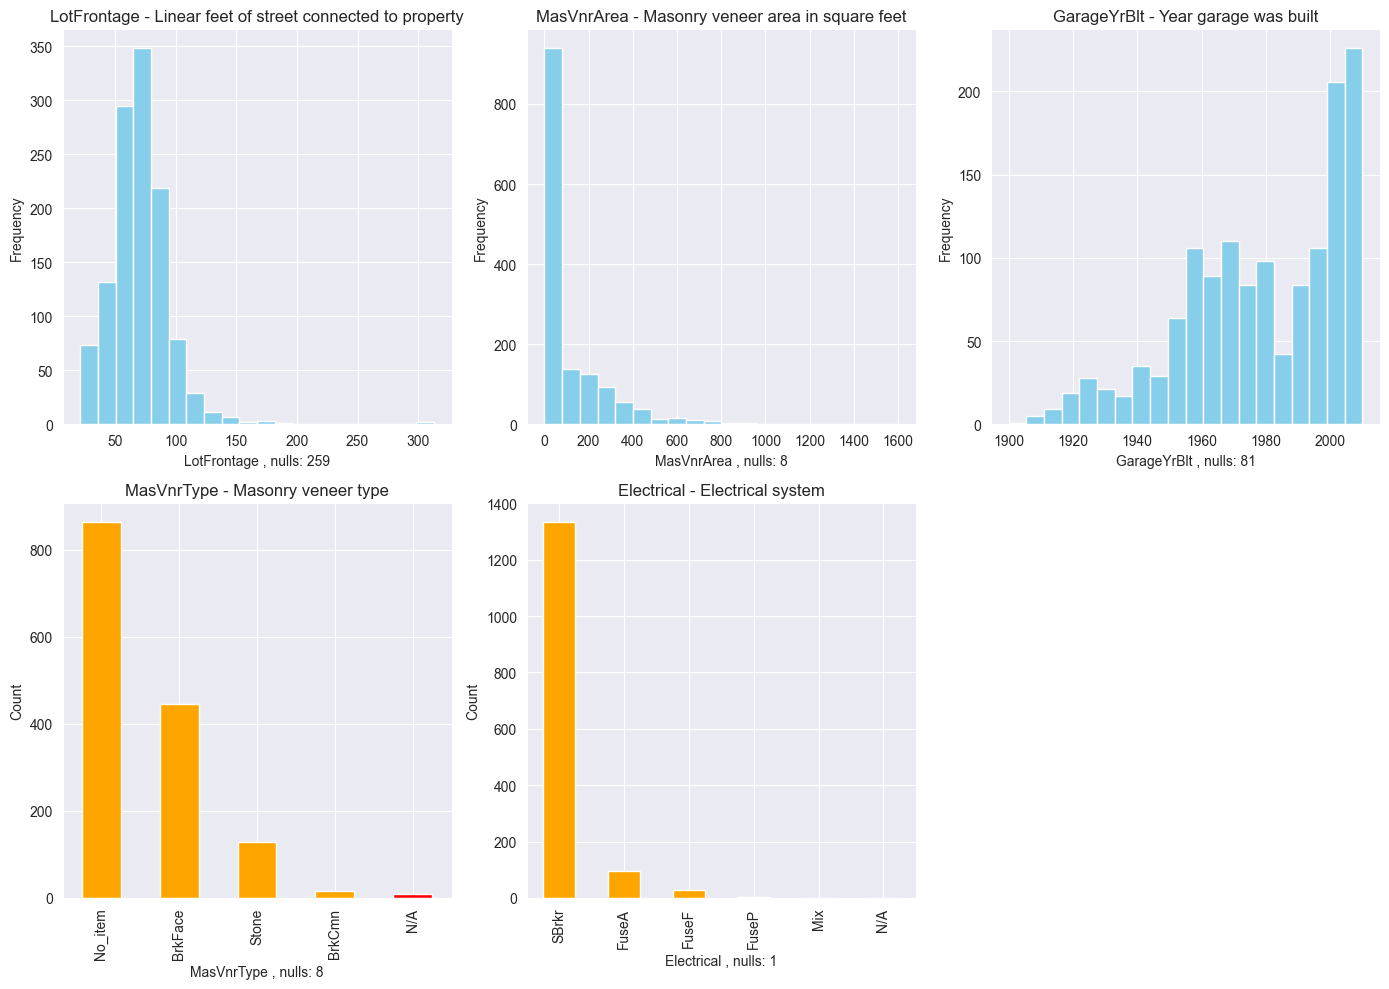

In [609]:
columns_with_nans = df.columns[df.isna().any()]
numeric_cols_with_nans = [col for col in columns_with_nans if df[col].dtype in ['int64', 'float64']]
categorical_cols_with_nans = [col for col in columns_with_nans if col not in numeric_cols_with_nans]

all_columns = numeric_cols_with_nans + categorical_cols_with_nans
num_cols = len(all_columns)

rows = ceil(num_cols / 3)
fig, axes = plt.subplots(rows, 3, figsize=(14, rows * 3 + 4))
axes = axes.flatten()

for i, col in enumerate(all_columns):
    ax = axes[i]
    title = col + " - " + columns_dict.get(col, "")
    x_label = col + " , nulls: " + str(df_nulls[col])
    if col in numeric_cols_with_nans:
        df[col].plot(kind='hist', bins=20, ax=ax, title=title, color='skyblue')
        ax.set_xlabel(x_label)
    elif col in categorical_cols_with_nans:
        value_counts = df[col].fillna("N/A").value_counts()
        colors = ["orange" if index != "N/A" else "red" for index in value_counts.index]
        value_counts.plot(kind='bar', ax=ax, title=title, color=colors)
        ax.set_xlabel(x_label)
        ax.set_ylabel("Count")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Now let's fill these values with medians for numerical features and modes for categorical

In [610]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())

For ordinal features we fill with -1 because it's supposed to work better than 0 for linear models

In [611]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(-1) 
df['Electrical'] = df['Electrical'].fillna(df['MasVnrArea'].median())

In [612]:
df.isna().any().sum() # no columns have nans

np.int64(0)

We eliminate abnormal observations for SalePrice

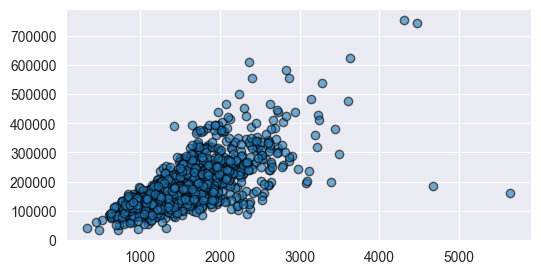

In [613]:
plt.figure(figsize=(6, 3))
plt.scatter(df['GrLivArea'], df['SalePrice'], alpha=0.6, edgecolor='k')

In [614]:
df = df[df.GrLivArea < 4000] # eliminate above 4000 sq. feet

Saving the data frame for later use.

In [615]:
# df.to_csv('train_preprocessed.csv')

Let's look at the dist of numerical features. It will help us identify for which features we might use log (or Box Cox) transformation.

In [616]:
numeric_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
numeric_cols.remove("MSSubClass")
numeric_cols.remove("OverallQual")
numeric_cols.remove("OverallCond")

categorical_cols = [col for col in df.columns if col not in numeric_cols]
ordinal_encode_cols = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "Street", "Alley", "PavedDrive"]
label_encode_cols = [col for col in categorical_cols if col not in ordinal_encode_cols]
ohe_encode_cols = label_encode_cols

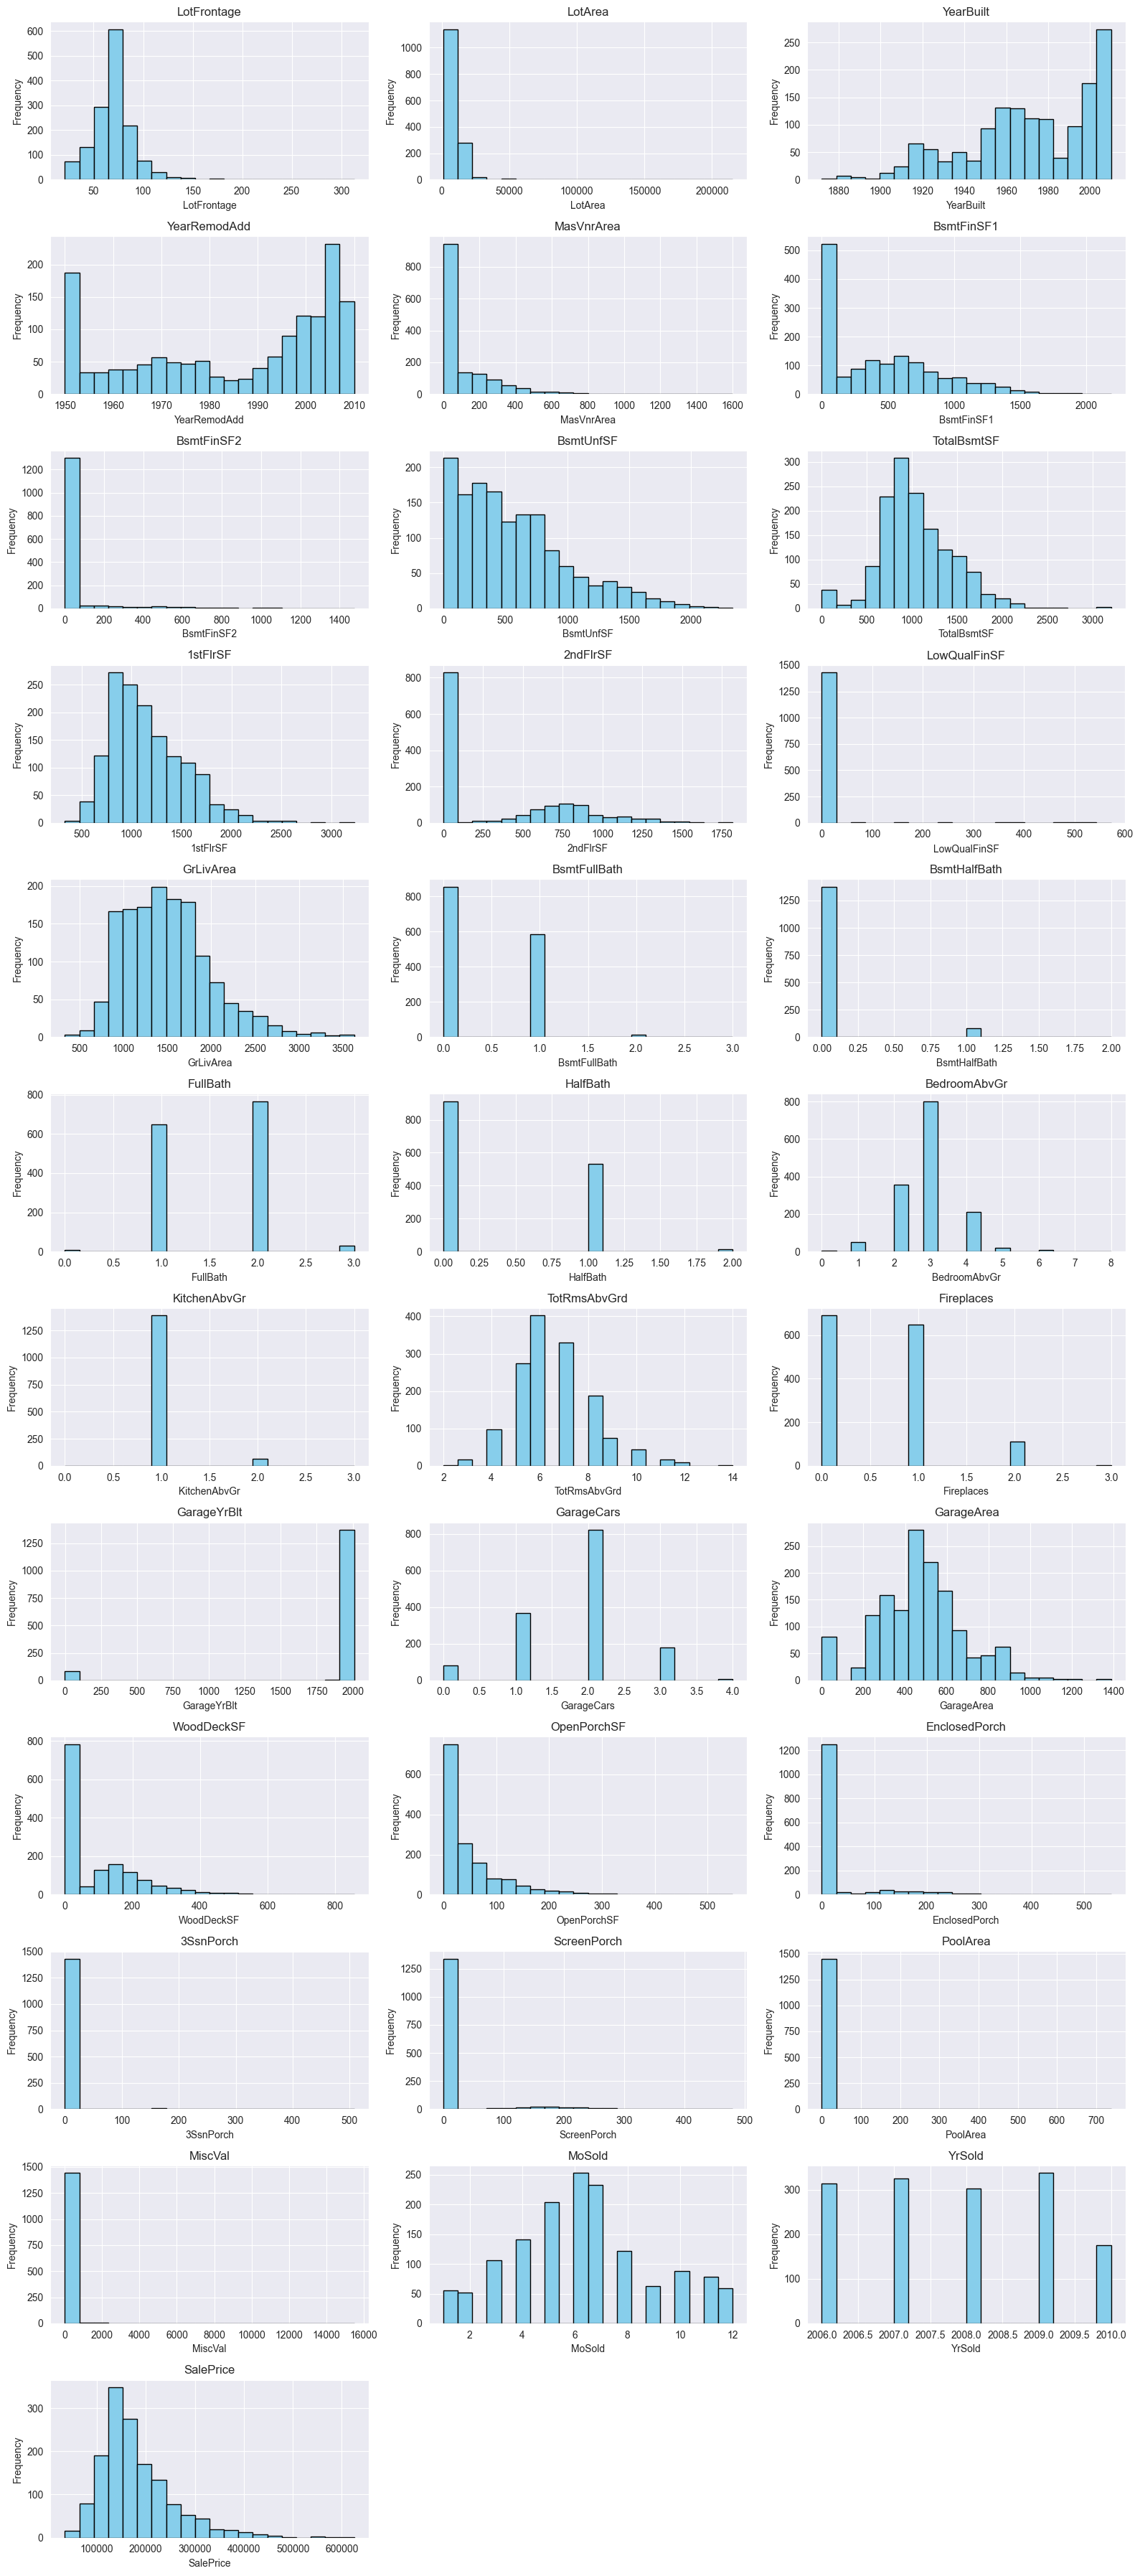

In [617]:
num_plots = len(numeric_cols)
cols = 3
rows = ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    df[col].plot(kind='hist', bins=20, ax=axes[i], title=col, color='skyblue', edgecolor='black')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We see quite a lot of highly skewed distributions. Would the log transformation help?

Lets create boxplots for numerical features

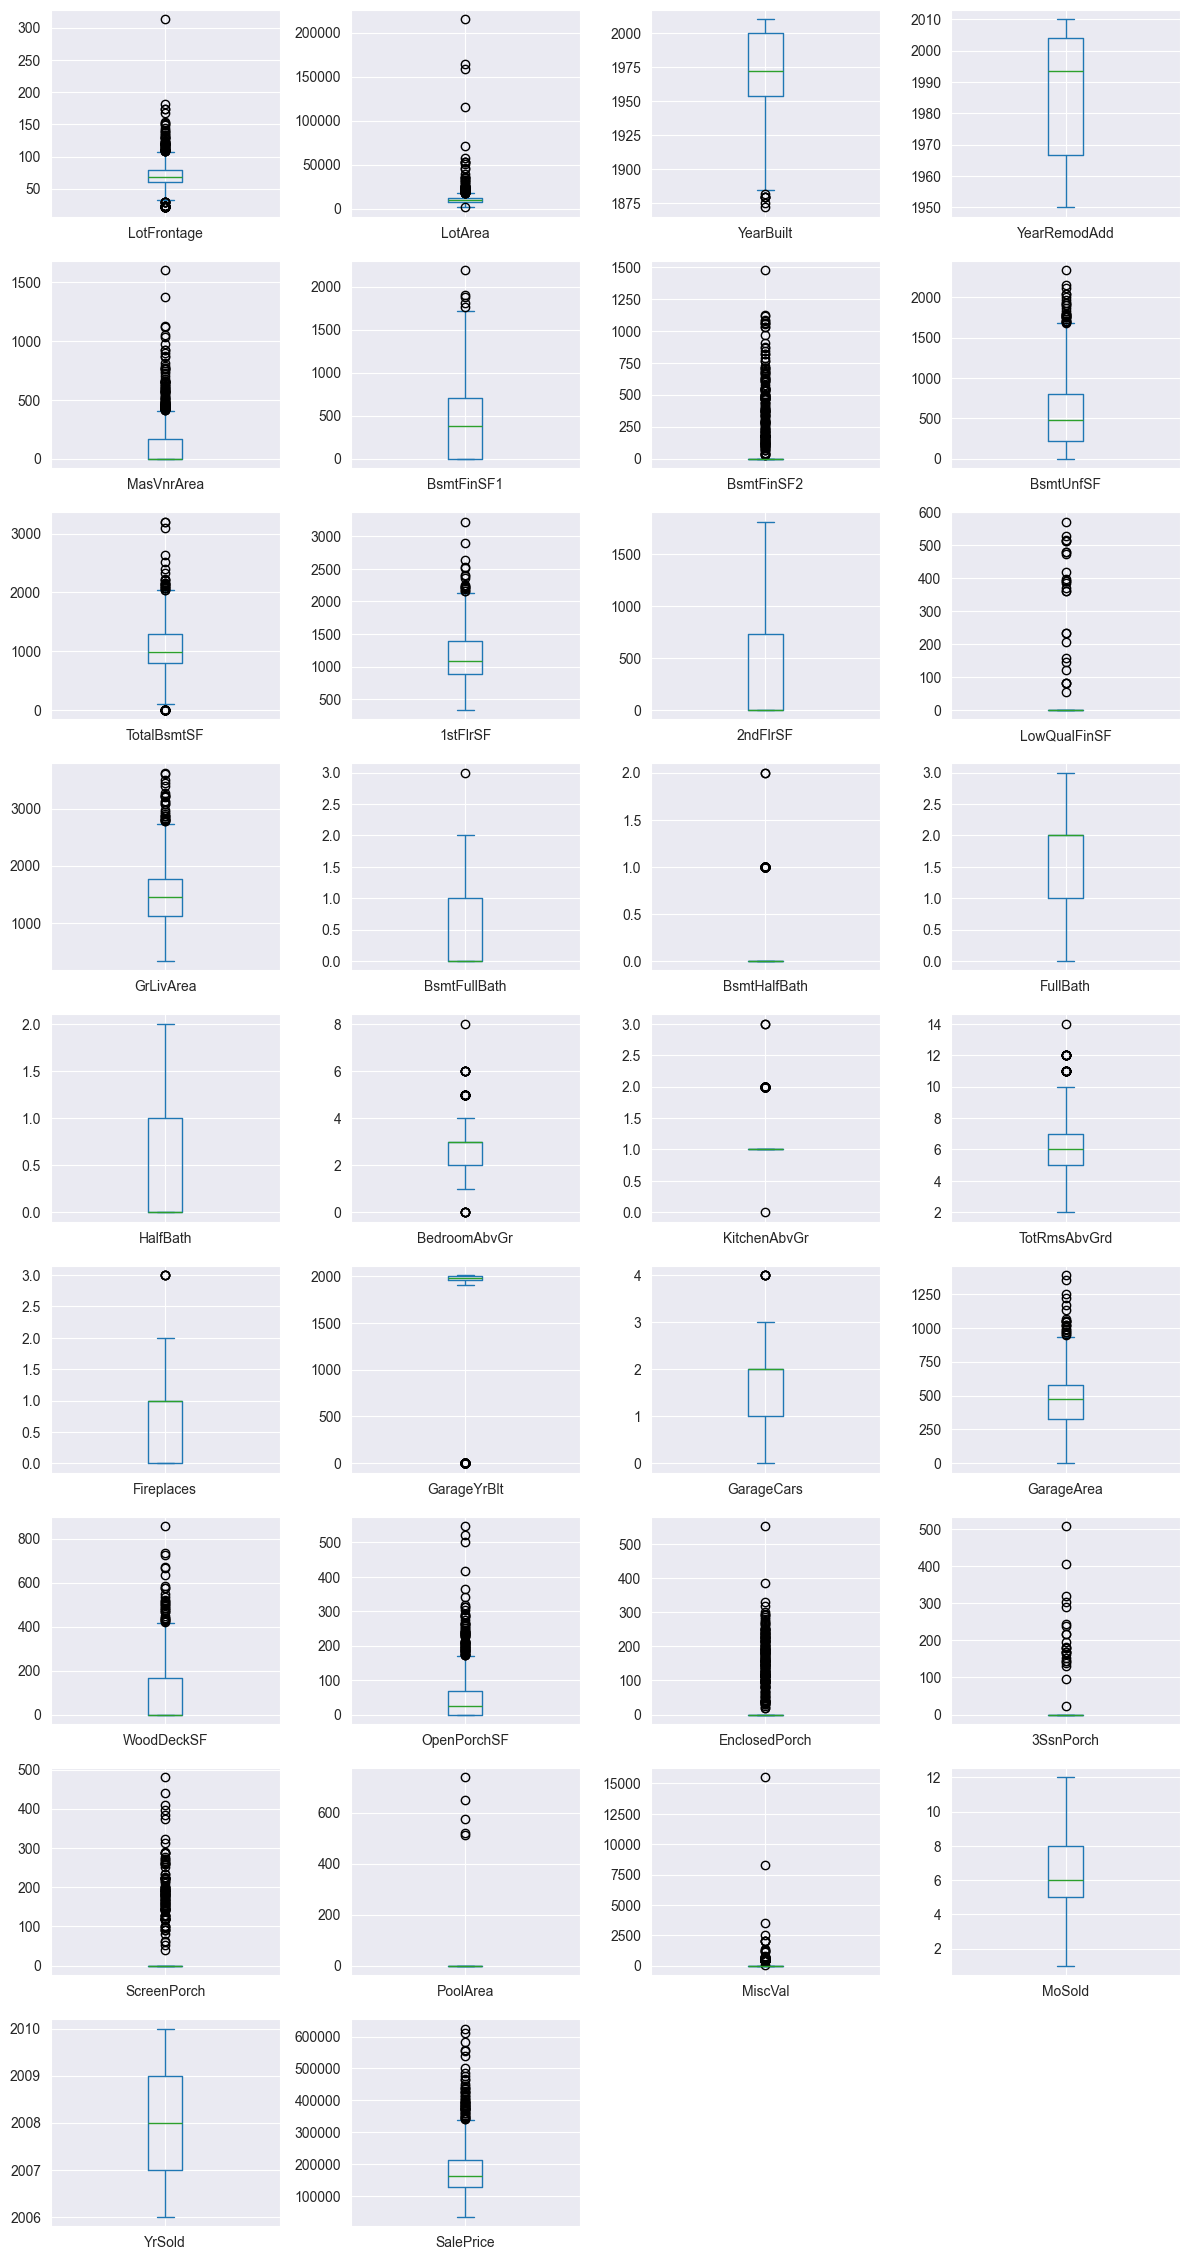

In [618]:
df[numeric_cols].plot(subplots=True, layout=(12,4), kind='box', figsize=(12, 30))
plt.tight_layout()
plt.show()

We can see that some of the features have quite a lot of extreme values. We don't want to completely eliminate them because they might contain important imformation and are not essentially outliers.
We want to know would we benefit from log transformation. In theory, for such models as LinearRegression, SVM (being metric-based), we may benefit from applying log transformation. We should try:
1. Transform year variables to the "how many years ago something happened". 
2. log-transform highly skewed numerical variables
3. Transform target SalePrice
 The columns to consider for these transformations: 

In [619]:
skewness = df[numeric_cols].apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

MiscVal         24.42
PoolArea        17.50
LotArea         12.57
3SsnPorch       10.28
LowQualFinSF     8.99
KitchenAbvGr     4.48
BsmtFinSF2       4.24
BsmtHalfBath     4.12
ScreenPorch      4.11
EnclosedPorch    3.08
MasVnrArea       2.65
OpenPorchSF      2.34
LotFrontage      1.71
SalePrice        1.56
WoodDeckSF       1.55
BsmtUnfSF        0.92
1stFlrSF         0.87
GrLivArea        0.83
2ndFlrSF         0.78
BsmtFinSF1       0.74
HalfBath         0.68
TotRmsAbvGrd     0.66
Fireplaces       0.63
BsmtFullBath     0.59
TotalBsmtSF      0.49
MoSold           0.22
BedroomAbvGr     0.21
GarageArea       0.13
YrSold           0.09
FullBath         0.02
GarageCars      -0.34
YearRemodAdd    -0.50
YearBuilt       -0.61
GarageYrBlt     -3.86
dtype: float64

In [627]:
features_with_high_skewness = list(skewness[abs(skewness) > 1].index)

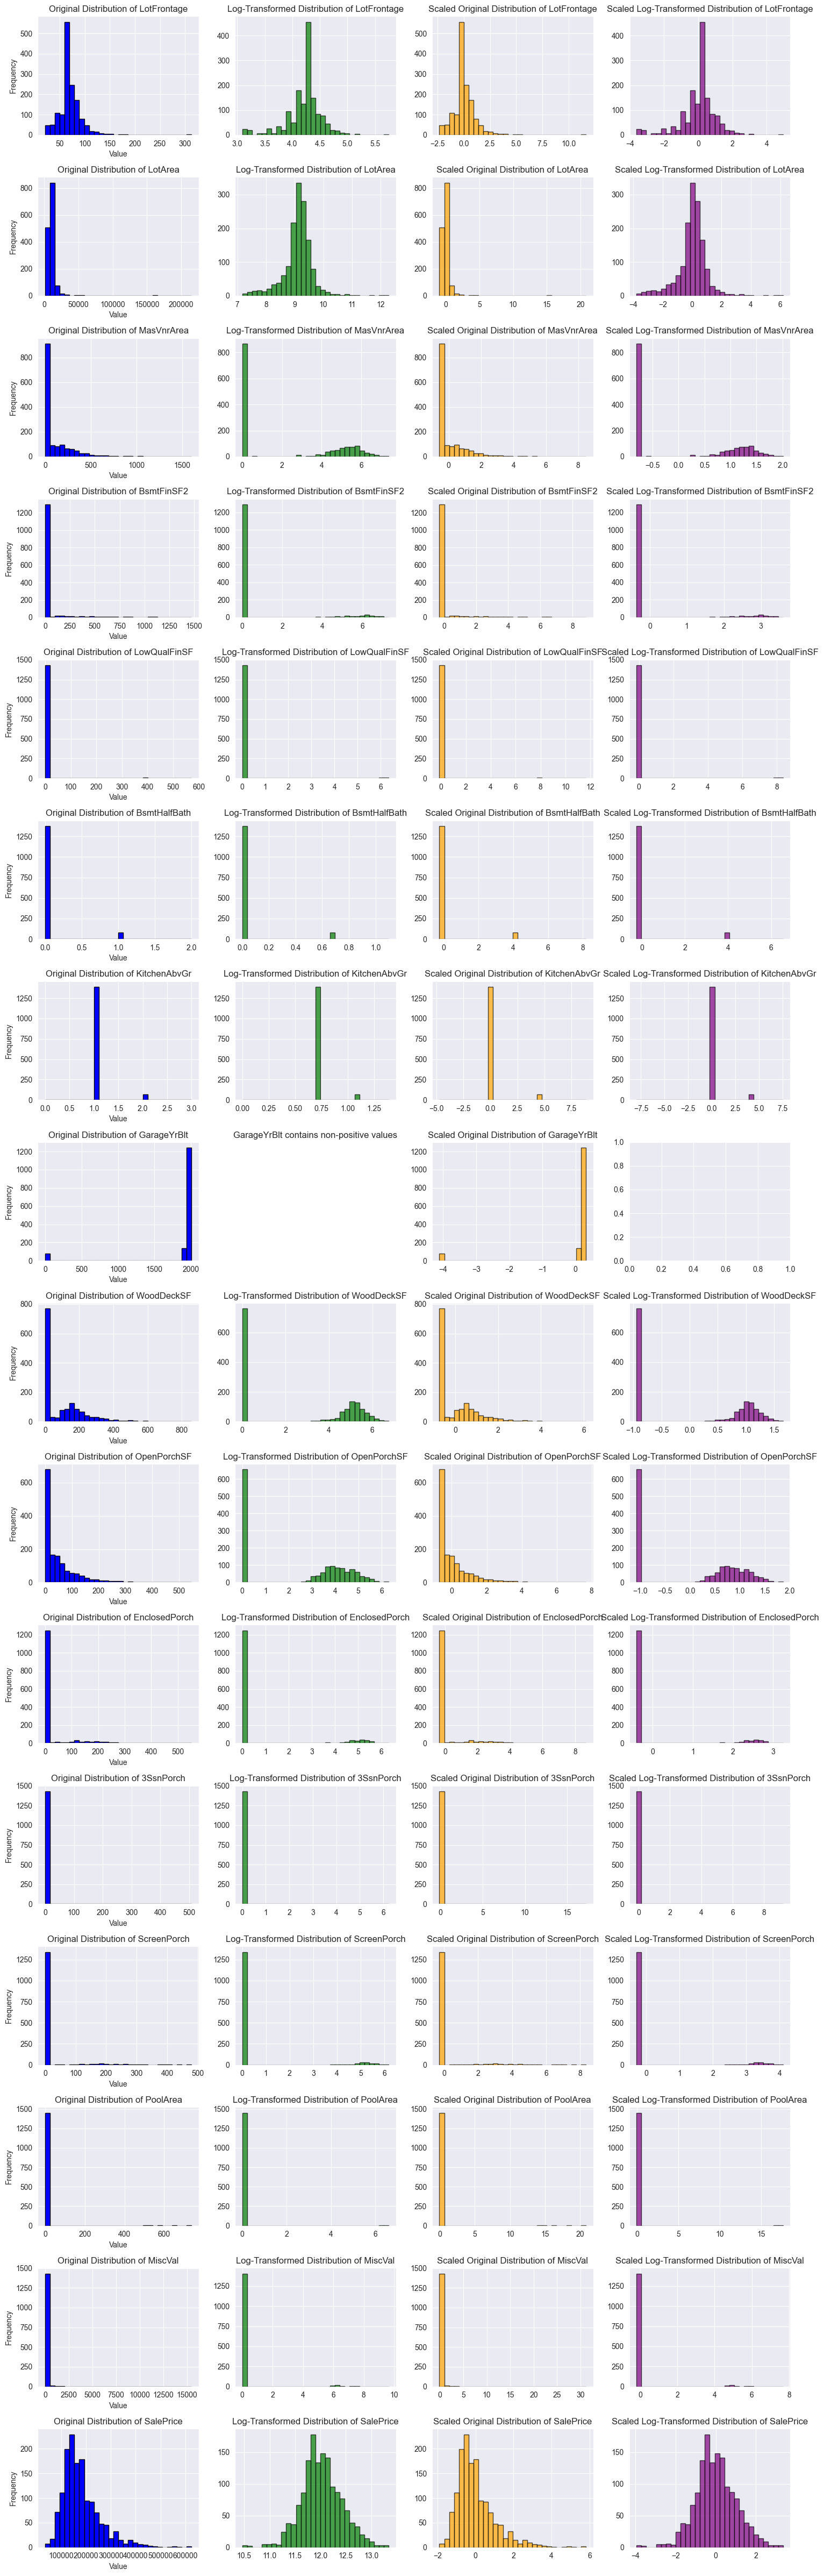

In [628]:
fig, axes = plt.subplots(len(features_with_high_skewness), 4, figsize=(15, 3 * len(features_with_high_skewness)))

scaler = StandardScaler()

for i, feature in enumerate(features_with_high_skewness):
    # Original Distribution
    axes[i, 0].hist(df[feature], bins=30, color="blue", edgecolor="black")
    axes[i, 0].set_title(f"Original Distribution of {feature}")
    axes[i, 0].set_xlabel("Value")
    axes[i, 0].set_ylabel("Frequency")

    # Log-Transformed Distribution
    if (df[feature] >= 0).all():
        log_transformed = np.log1p(df[feature])
        axes[i, 1].hist(log_transformed, bins=30, color="green", edgecolor="black", alpha=0.7)
        axes[i, 1].set_title(f"Log-Transformed Distribution of {feature}")
    else:
        axes[i, 1].set_title(f"{feature} contains non-positive values")
        axes[i, 1].axis('off')

    # Standard Scaled Original Distribution
    scaled_original = scaler.fit_transform(df[[feature]])
    axes[i, 2].hist(scaled_original, bins=30, color="orange", edgecolor="black", alpha=0.7)
    axes[i, 2].set_title(f"Scaled Original Distribution of {feature}")

    # Standard Scaled Log-Transformed Distribution
    if (df[feature] >= 0).all():
        scaled_log_transformed = scaler.fit_transform(log_transformed.values.reshape(-1, 1))
        axes[i, 3].hist(scaled_log_transformed, bins=30, color="purple", edgecolor="black", alpha=0.7)
        axes[i, 3].set_title(f"Scaled Log-Transformed Distribution of {feature}")

plt.tight_layout()
plt.show()

In [ ]:
year_columns = ['YrSold', 'GarageYrBlt', 'YearRemodAdd', 'YearRemodAdd']
numerical_skewed_columns = ['LotFrontage', 'LotArea', 'MasVnrArea']

Correlations of the target variable with numerical features

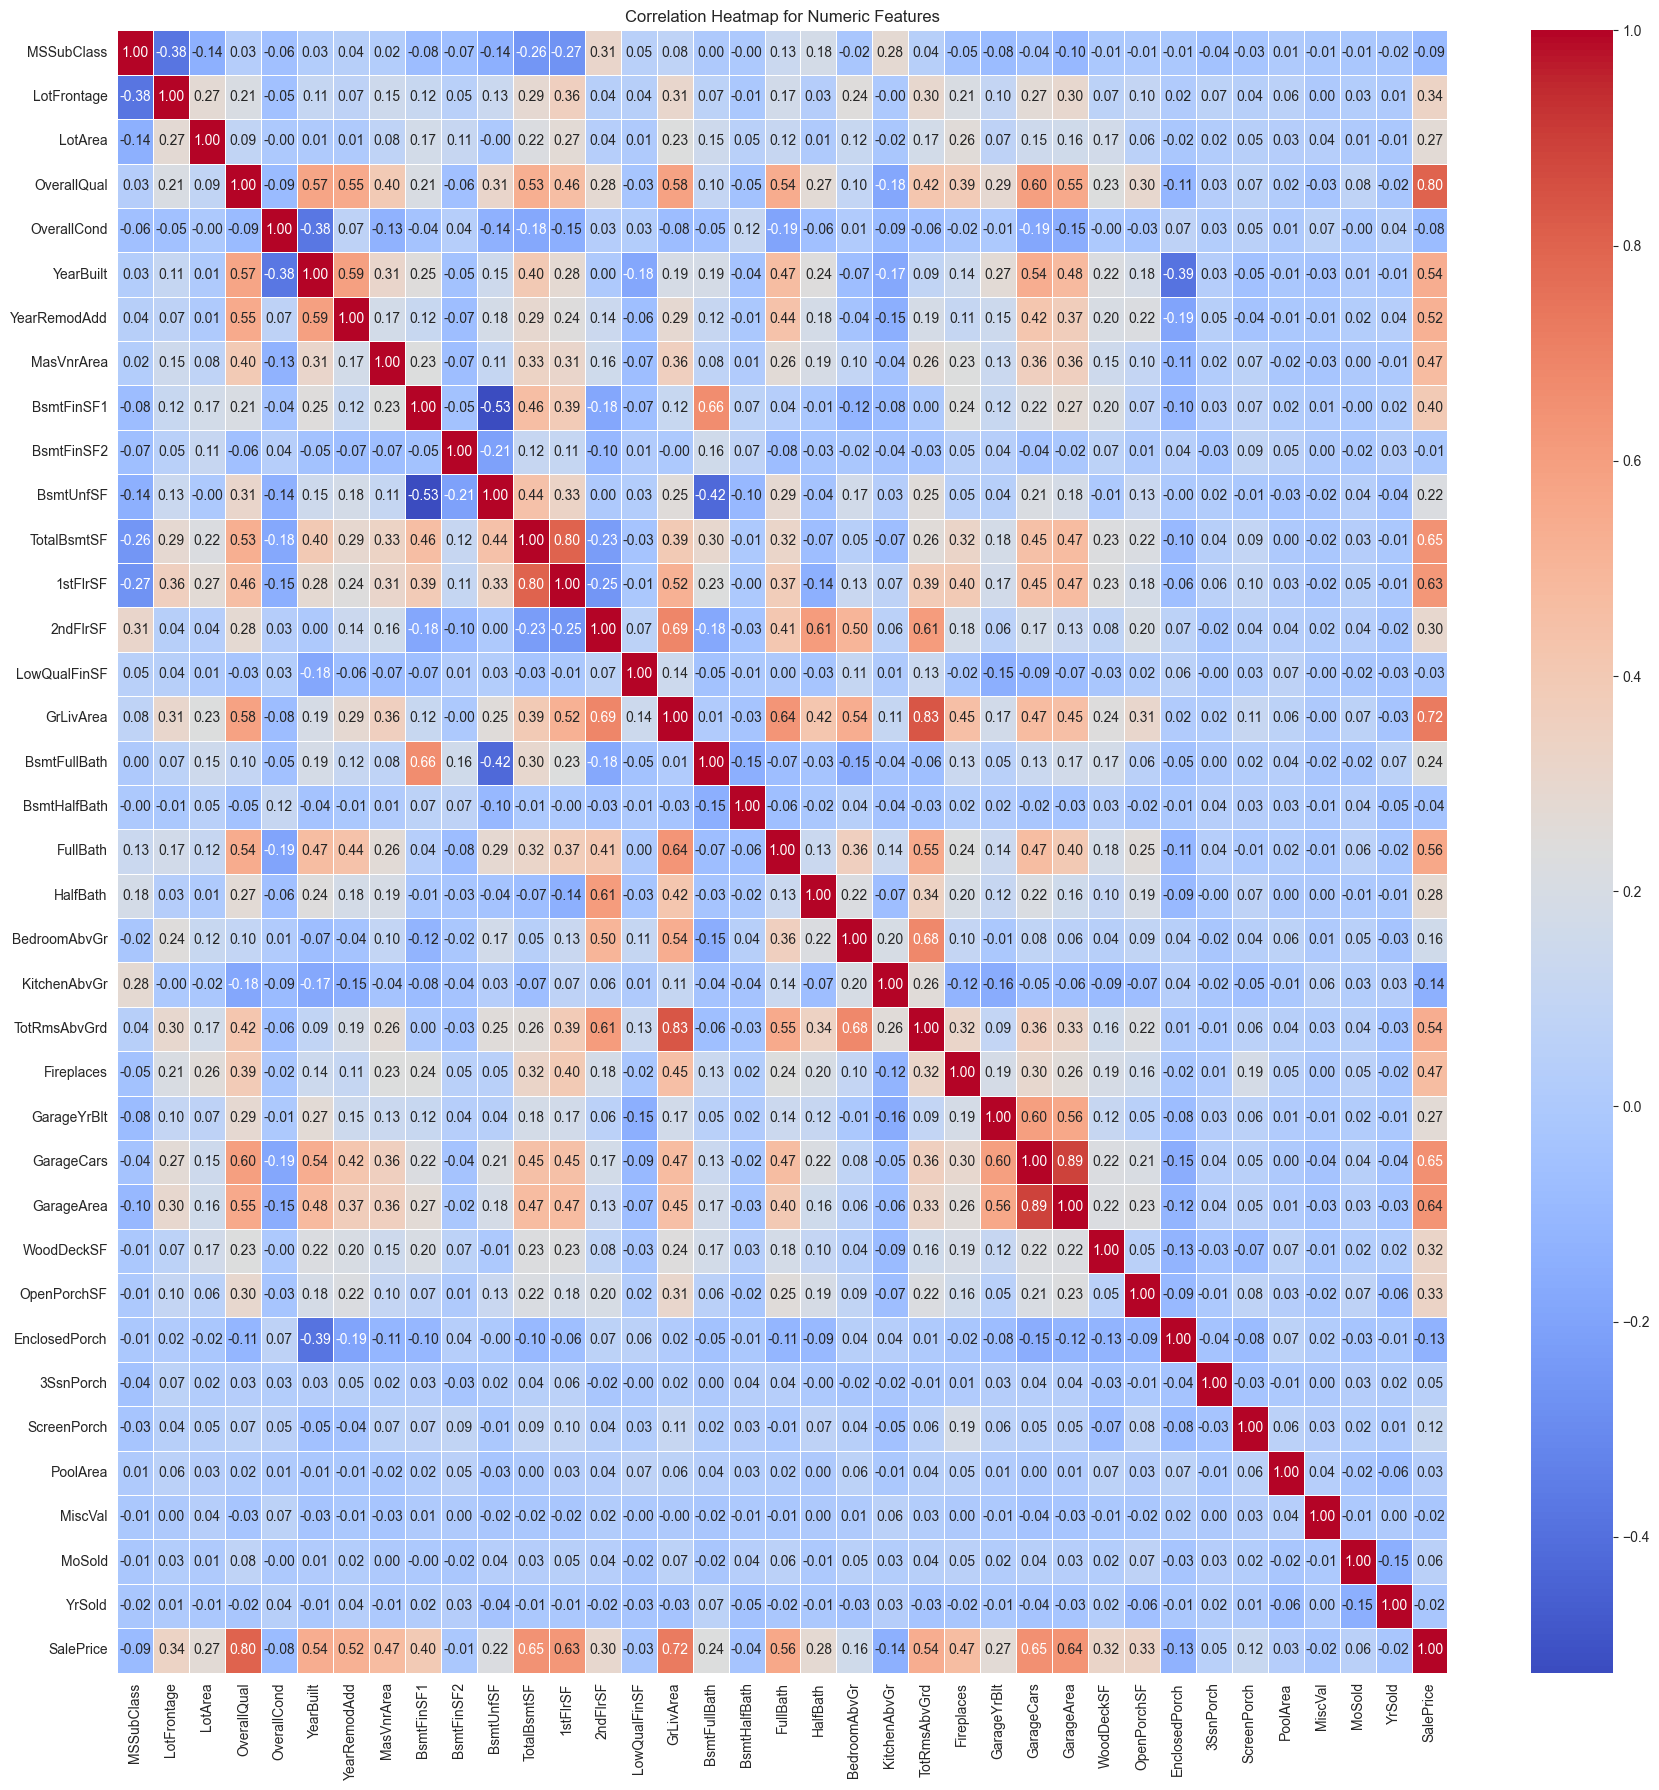

In [250]:
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap for Numeric Features")
plt.tight_layout()
plt.show()

Finding correlations above threshold

In [251]:
threshold = 0.5

upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

highly_correlated_pairs = upper_triangle.stack().reset_index()
highly_correlated_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
highly_correlated_pairs = highly_correlated_pairs[
    abs(highly_correlated_pairs['Correlation']) > threshold
]

In [252]:
highly_correlated_pairs.sort_values(by='Correlation', ascending=False) # high correlations above threshold

Feature 1     Feature 2  Correlation
600    GarageCars    GarageArea     0.886882
441     GrLivArea  TotRmsAbvGrd     0.833979
137   OverallQual     SalePrice     0.800858
341   TotalBsmtSF      1stFlrSF     0.800759
455     GrLivArea     SalePrice     0.720516
391      2ndFlrSF     GrLivArea     0.687430
531  BedroomAbvGr  TotRmsAbvGrd     0.679346
267    BsmtFinSF1  BsmtFullBath     0.661933
610    GarageCars     SalePrice     0.649256
365   TotalBsmtSF     SalePrice     0.646584
620    GarageArea     SalePrice     0.636964
437     GrLivArea      FullBath     0.635161
389      1stFlrSF     SalePrice     0.625235
398      2ndFlrSF  TotRmsAbvGrd     0.610794
395      2ndFlrSF      HalfBath     0.609022
126   OverallQual    GarageCars     0.598739
588   GarageYrBlt    GarageCars     0.598722
170     YearBuilt  YearRemodAdd     0.591906
116   OverallQual     GrLivArea     0.583519
106   OverallQual     YearBuilt     0.571712
589   GarageYrBlt    GarageArea     0.564445
512      FullBath     SalePrice     0.559048
127   OverallQual    GarageArea     0.554905
107   OverallQual  YearRemodAdd     0.550971
498      FullBath  TotRmsAbvGrd     0.549625
119   OverallQual      FullBath     0.543791
439     GrLivArea  BedroomAbvGr     0.540083
574  TotRmsAbvGrd     SalePrice     0.537462
189     YearBuilt    GarageCars     0.536749
200     YearBuilt     SalePrice     0.535279
112   OverallQual   TotalBsmtSF     0.532666
368      1stFlrSF     GrLivArea     0.522920
230  YearRemodAdd     SalePrice     0.521428
396      2ndFlrSF  BedroomAbvGr     0.502450
261    BsmtFinSF1     BsmtUnfSF    -0.526140

In [253]:
highly_correlated_pairs.loc[highly_correlated_pairs['Feature 2'] == 'SalePrice', :].sort_values(by='Correlation', ascending=False) # correlation with target 

Feature 1  Feature 2  Correlation
137   OverallQual  SalePrice     0.800858
455     GrLivArea  SalePrice     0.720516
610    GarageCars  SalePrice     0.649256
365   TotalBsmtSF  SalePrice     0.646584
620    GarageArea  SalePrice     0.636964
389      1stFlrSF  SalePrice     0.625235
512      FullBath  SalePrice     0.559048
574  TotRmsAbvGrd  SalePrice     0.537462
200     YearBuilt  SalePrice     0.535279
230  YearRemodAdd  SalePrice     0.521428

To identify which features to ordinary encode, we create these plots

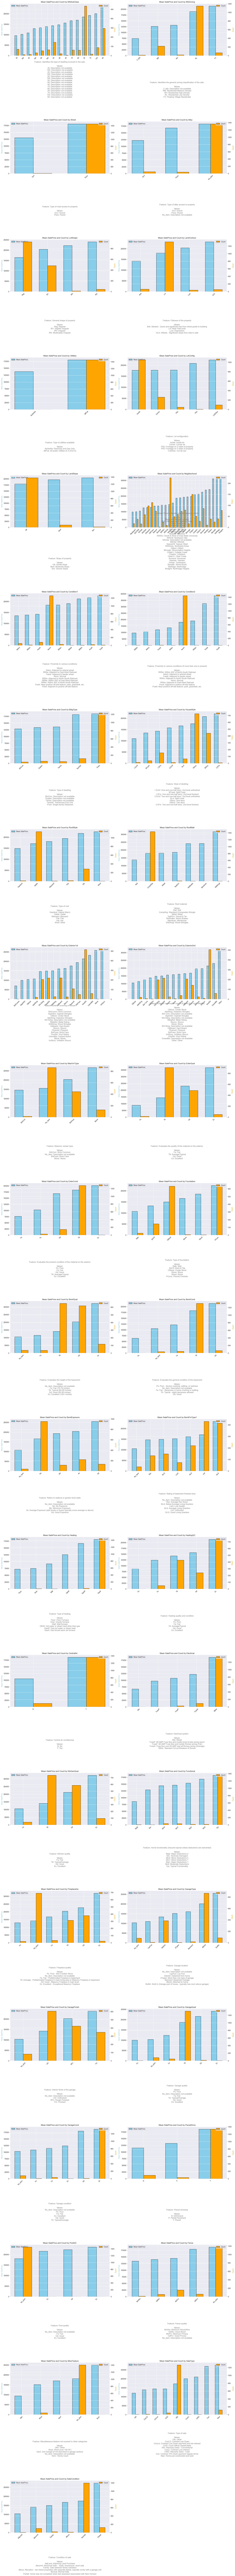

In [277]:
mean_comparison_results = {}
target_column = 'SalePrice'

num_plots = len(categorical_cols)
cols = 2
rows = ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    category_means = df.groupby(col)[target_column].mean()
    category_counts = df[col].value_counts()
    sorted_categories = category_means.sort_values().index
    sorted_means = category_means[sorted_categories]
    sorted_counts = category_counts[sorted_categories]
    mean_comparison_results[col] = sorted_means
    x = np.arange(len(sorted_categories))

    ax1 = axes[i]
    ax2 = ax1.twinx()

    bar_width = 0.35

    ax1.bar(x - bar_width / 2, sorted_means, width=bar_width, color='skyblue', edgecolor='black', label='Mean SalePrice')
    ax2.bar(x + bar_width / 2, sorted_counts, width=bar_width, color='orange', edgecolor='black', label='Count')

    ax1.set_title(f"Mean {target_column} and Count by {col}")
    ax1.set_xticks(x)
    ax1.set_xticklabels(sorted_categories, rotation=45)
    ax1.set_ylabel("Mean SalePrice", color='skyblue')
    ax2.set_ylabel("Count", color='orange')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    feature_description = feature_dict.get(col, {}).get("desc", "Description not available")
    value_descriptions = feature_dict.get(col, {}).get("values", {})
    sorted_value_desc_text = "\n".join(
        [f"{key}: {value_descriptions.get(key, 'Description not available')}" for key in sorted_categories]
    )

    full_description = f"Feature: {feature_description}\n\nValues:\n{sorted_value_desc_text}"

    ax1.text(
        0.5, -0.8, full_description, transform=ax1.transAxes, ha="center", fontsize=12, color="gray", wrap=True
    )

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The columns to ordinary encode:

In [ ]:
ordinal_columns = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "Street", "Alley", "PavedDrive"]

We create .json file to store data about variables: their description and possible categories for categorical features

In [278]:
# # columns_dict, dict with dict with features and descriptions
# with open("columns_description.txt", "r") as file:
#     lines = file.readlines()
# 
# columns_dict = {}
# for line in lines:
#     if ": " in line:  # Ensure the line contains a key-value separator
#         key, value = line.strip().split(": ", 1)
#         columns_dict[key] = value
# 
# with open("columns_dict.json", "w") as json_file:
#     json.dump(columns_dict, json_file, indent=4)
# 
# structured_data = defaultdict(lambda: {"desc": "", "values": {}})
# 
# with open("data_description.txt", "r") as file:
#     lines = file.readlines()
# 
# current_feature = None
# 
# for line in lines:
#     feature_match = re.match(r"(\w+):\s+(.+)", line)
#     if feature_match:
#         current_feature = feature_match.group(1)
#         structured_data[current_feature]["desc"] = feature_match.group(2)
#     elif current_feature:
#         value_match = re.match(r"^\s*(\S+)\s+(.+)", line)
#         if value_match:
#             key = value_match.group(1)
#             value = value_match.group(2)
#             structured_data[current_feature]["values"][key] = value
# 
# structured_data = dict(structured_data)
# 
# with open("feature_dict.json", "w") as json_file:
#     json.dump(structured_data, json_file, indent=4)

In [280]:
encoding_mappings = {}

for col in ordinal_columns:
    if col in df.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        encoding_mappings[col] = mapping

In [281]:
encoding_mappings

{'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'BsmtQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'BsmtCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'BsmtExposure': {'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5, 'No_item': -1},
 'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'FireplaceQu': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'GarageQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'GarageCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'PoolQC': {'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'Street': {'Grvl': 1, 'Pave': 2, 'No_item': -1},
 'Alley': {'Grvl': 2, 'Pave': 3, 'No_item': -1},
 'PavedDrive': {'N': 1, 'P': 2, 'Y': 3, 'No_item': -1}}

## 3. Evaluation

3.1 Importing dictionaries and data

In [553]:
with open("feature_dict.json", "r") as json_file:
    feature_dict = json.load(json_file)

In [554]:
df = pd.read_csv('train_prepared_for_cv.csv')

In [555]:
sum(df.isna().sum())

357

In [556]:
X = df.drop(columns=['Id', 'SalePrice'])
y = df['SalePrice']

In [557]:
numeric_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
numeric_cols.remove("MSSubClass")
numeric_cols.remove("OverallQual")
numeric_cols.remove("OverallCond")

categorical_cols = [col for col in X.columns if col not in numeric_cols]
ordinal_encode_cols = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "Street", "Alley", "PavedDrive"]
label_encode_cols = [col for col in categorical_cols if col not in ordinal_encode_cols]
ohe_encode_cols = label_encode_cols

Numerical columns

In [558]:
print(numeric_cols)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


Categorical columns

In [559]:
print(categorical_cols)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


Ordinal columns

In [560]:
print(ordinal_encode_cols)

['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Street', 'Alley', 'PavedDrive']


Label/OHE encode columns

In [561]:
print(label_encode_cols)

['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [291]:
print("# of categorical columns", len(categorical_cols))
print(len(ordinal_encode_cols), len(label_encode_cols), len(ohe_encode_cols))
print(len(ordinal_encode_cols) + len(label_encode_cols))
print(len(numeric_cols))
print(len(numeric_cols) + len(categorical_cols))

43
14 29 29
43
35
78


### 3.2 Creating mappings for categorical columns

Since some of the columns does not have all the categories, we create mappings. It will also help us to ensure correct mappings on cross validation, so we won't miss any categories due to their absence on a particular fold.

In [292]:
ordinal_mappings = {}

for col in ordinal_encode_cols:
    if col in X.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        ordinal_mappings[col] = mapping
        
def safe_map(value, mapping):
    if value not in mapping:
        raise ValueError(f"Value '{value}' not found in the mapping!")
    return mapping[value]

def ordinal_encode_column(X, mappings):
    encoded = X.copy()
    for col in X.columns:
        if col in mappings:
            encoded[col] = X.apply(lambda x: safe_map(x, mappings[col]))
    return encoded

print(ordinal_mappings)

{'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'BsmtQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'BsmtCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'BsmtExposure': {'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5, 'No_item': -1}, 'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'FireplaceQu': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'GarageQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'GarageCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'PoolQC': {'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'Street': {'Grvl': 1, 'Pave': 2, 'No_item': -1}, 'Alley': {'Grvl': 2, 'Pave': 3, 'No_item': -1}, 'PavedDrive': {'N': 1, 'P': 2, 'Y': 3, 'No_item': -1}}


In [293]:
label_mappings = {}

for col in label_encode_cols:
    if col in X.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        label_mappings[col] = mapping
        
def safe_map(value, mapping):
    if value not in mapping:
        raise ValueError(f"Value '{value}' not found in the mapping!")
    return mapping[value]

def label_encode_column(X, mappings):
    encoded = X.copy()
    for col in X.columns:
        if col in mappings:
            encoded[col] = df[col].apply(lambda x: safe_map(x, mappings[col]))
    return encoded

print(label_mappings)

{'MSSubClass': {'190': 1, '180': 2, '160': 3, '150': 4, '120': 5, '90': 6, '85': 7, '80': 8, '75': 9, '70': 10, '60': 11, '50': 12, '45': 13, '40': 14, '30': 15, '20': 16, 'No_item': -1}, 'MSZoning': {'RM': 1, 'RP': 2, 'RL': 3, 'RH': 4, 'I': 5, 'FV': 6, 'C': 7, 'A': 8, 'No_item': -1}, 'LotShape': {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4, 'No_item': -1}, 'LandContour': {'Low': 1, 'HLS': 2, 'Bnk': 3, 'Lvl': 4, 'No_item': -1}, 'Utilities': {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4, 'No_item': -1}, 'LotConfig': {'FR3': 1, 'FR2': 2, 'CulDSac': 3, 'Corner': 4, 'Inside': 5, 'No_item': -1}, 'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3, 'No_item': -1}, 'Neighborhood': {'Veenker': 1, 'Timber': 2, 'StoneBr': 3, 'Somerst': 4, 'SawyerW': 5, 'Sawyer': 6, 'SWISU': 7, 'OldTown': 8, 'NWAmes': 9, 'NridgHt': 10, 'NPkVill': 11, 'NoRidge': 12, 'Names': 13, 'Mitchel': 14, 'MeadowV': 15, 'IDOTRR': 16, 'Gilbert': 17, 'Edwards': 18, 'Crawfor': 19, 'CollgCr': 20, 'ClearCr': 21, 'BrkSide': 22, 'BrDale': 23, 

### 3.3 Creating functions and classes for evaluation and training

In [294]:
class DataFramePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, ordinal_cols, ohe_cols, label_cols, ordinal_mappings, label_mappings, features_to_scale):
        self.numeric_cols = numeric_cols
        self.ordinal_cols = ordinal_cols
        self.ohe_cols = ohe_cols
        self.label_cols = label_cols
        self.ordinal_mappings = ordinal_mappings
        self.label_mappings = label_mappings
        self.ohe_columns_names = None
        self.medians = {}
        self.modes = {}
        self.scaler = StandardScaler()
        self.features_to_scale = features_to_scale

    def fit(self, X, y=None):
        self.medians = X[self.numeric_cols].median()
        self.modes = X[self.ordinal_cols + self.ohe_cols + self.label_cols].mode().iloc[0]
        if self.ohe_cols:
            self.ohe_columns_names = []
            for col in self.ohe_cols:
                if col in feature_dict:
                    categories = feature_dict[col]["values"].keys()
                    for category in categories:
                        self.ohe_columns_names.append(f"{col}_{category}")
                else:
                    raise KeyError(f"Feature {col} not found in feature dictionary")
        return self

    def transform(self, X):
        X = X.copy()
        # filling NA
        for col in self.numeric_cols:
            X[col] = X[col].fillna(self.medians[col])
        
        skewness = X[numeric_cols].apply(lambda x: skew(x))
        skewness = skewness[abs(skewness) > 0.5]
        skewed_features = skewness.index
        X[skewed_features] = np.log1p(X[skewed_features])
    
        if X.columns.duplicated().any():
                raise ValueError(f"Duplicate column names found: {X.columns[X.columns.duplicated()].tolist()}")

        for col in self.ordinal_cols + self.ohe_cols + self.label_cols:
            X[col] = X[col].fillna(self.modes[col])
        
        for col in self.ordinal_cols:
            if col in self.ordinal_mappings:
                X[col] = X[col].map(self.ordinal_mappings[col])
            else:
                raise KeyError
        
        for col in self.label_cols:
            if col in self.label_mappings:
                X[col] = X[col].map(self.label_mappings[col])
            else:
                raise KeyError
        
        if self.features_to_scale:
            X[self.features_to_scale] = self.scaler.fit_transform(X[self.features_to_scale])

        
        if self.ohe_cols:
            ohe_encoded = pd.DataFrame(0, index=X.index, columns=self.ohe_columns_names)
            for col in self.ohe_cols:
                if col in feature_dict:
                    categories = feature_dict[col]["values"].keys()
                    for category in categories:
                        ohe_col_name = f"{col}_{category}"
                        ohe_encoded[ohe_col_name] = (X[col] == category).astype(int)
                else:
                    raise KeyError(f"Feature {col} not found in feature dictionary")
                
            X = X.drop(columns=self.ohe_cols)
            X = pd.concat([X, ohe_encoded], axis=1)
            
        return X

In [295]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=ohe_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols
)

In [296]:
# testing preprocessing
processed_data = preprocessor.fit_transform(X)

Initializing features that have high skewness from our previous analysis. The performance on log transformed features was worse, so we decided not to use it.

In [297]:
# These feature have skewness > 0.5
# skewed_cols = ['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'MasVnrArea',
#        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
#        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
#        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
#        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
#        'ScreenPorch', 'PoolArea', 'MiscVal']

Creating a function to train and validate models on cross-validation.

In [299]:
def run_model(model_class, param_grid, preprocessor, X, y):
    
    kf = KFold(n_splits=9, shuffle=True, random_state=42)
    
    r2 = {"train": [], "test": []}
    mae = {"train": [], "test": []}
    best_params = []
    feature_importances = pd.DataFrame(index=preprocessor.fit_transform(X).columns)

    for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X), 1)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        preprocessor.fit(X_train)
        X_train_preprocessed = preprocessor.transform(X_train)
        X_test_preprocessed = preprocessor.transform(X_test)
                
        model = model_class()
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train_preprocessed, y_train)
        
        best_params.append(grid_search.best_params_)
        
        model = model_class(**grid_search.best_params_)
        model.fit(X_train_preprocessed, y_train)
        
        y_train_pred = model.predict(X_train_preprocessed)
        y_test_pred = model.predict(X_test_preprocessed)
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        r2["train"].append(train_r2)
        r2["test"].append(test_r2)
        mae["train"].append(train_mae)
        mae["test"].append(test_mae)
        
        
        # if hasattr(model, "coef_"):
        #     print(f"Model {model_class} has coef_ attribute")
        #     print(model.coef_)
        # if hasattr(model, "feature_importances_"):
        #     print(f"Model {model_class} has feature_importances_ attribute")
        #     print(model.feature_importances_)
        
        if model_class == XGBRegressor:
            gain_importance = model.get_booster().get_score(importance_type='gain')
            fold_importances = pd.Series(gain_importance)
        else:
            if hasattr(model, "coef_"):
                try:
                    fold_importances = pd.Series(np.abs(model.coef_), index=X.columns)
                except:
                    fold_importances = pd.Series(np.abs(model.coef_), index=X_train_preprocessed.columns)

            elif hasattr(model, "feature_importances_"):    
                try:
                    fold_importances = pd.Series(model.feature_importances_, index=X.columns)
                except:
                    fold_importances = pd.Series(model.feature_importances_, index=X_train_preprocessed.columns)
            else:
                raise AttributeError(f"The model {model_class.__name__} does not support feature importance extraction.")

        common_indices = set(feature_importances.index) & set(fold_importances.index)
        if not common_indices:
            raise ValueError("No corresponding string indices found in the left DataFrame.")
        # feature_importances = pd.concat([feature_importances, fold_importances], axis=1)
        feature_importances = feature_importances.merge(fold_importances.rename(f"{fold}"), left_index=True, right_index=True, how='outer')


    feature_importances['mean_importance'] = feature_importances.mean(axis=1)
    feature_importances = feature_importances[['mean_importance']].sort_values(by='mean_importance', ascending=False)
    
    return pd.DataFrame(r2), pd.DataFrame(mae), feature_importances, best_params

### 3.4 Model evaluating

#### 3.4.1 Model performance based on scaling and encoding

Although it's a common practice to encode categorical features using One-How-Encoding and scale numerical and ordinal features for linear models like Lasso and ElasticNet, we evaluated performance of the models for different encoding of categorical features. This section explores the differences in performance based on these encoding and scaling.

In [395]:
import os
sys.stderr = open(os.devnull, 'w')

In [396]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=[],
    label_cols=label_encode_cols,
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=[]
)

Creating models we will use, parameter grids, and various data preprocessors.

In [397]:
models = [LinearRegression, Lasso, ElasticNet, XGBRegressor, RandomForestRegressor]

param_grids = [
    {},
    {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    },
    {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
    },
    {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 9],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [0, 0.5, 1],
        'nthread': [-1],
    },
    # {
    #     'C': [10, 100, 1000, 100000, 200000, 300000],
    #     'kernel': ['rbf', 'poly'],
    #     'gamma': ['auto', 0.01, 0.1, 1, 10],
    #     'epsilon': [0, 0.1, 0.5, 1]
    #  },
    {
        'n_estimators': [300],
        'min_samples_leaf': [3, 5, 10, 20],
        'max_depth': [5, 10, 15, 20, None],
        'n_jobs': [-1],
    }
]

preprocessors = [
    DataFramePreprocessor(
        numeric_cols=numeric_cols,
        ordinal_cols=ordinal_encode_cols,
        ohe_cols=[],
        label_cols=label_encode_cols,
        ordinal_mappings=ordinal_mappings,
        label_mappings=label_mappings,
        features_to_scale=[]
    ),
    DataFramePreprocessor(
        numeric_cols=numeric_cols,
        ordinal_cols=ordinal_encode_cols,
        ohe_cols=[],
        label_cols=label_encode_cols,
        ordinal_mappings=ordinal_mappings,
        label_mappings=label_mappings,
        features_to_scale=numeric_cols + ordinal_encode_cols + label_encode_cols
    ),
    
    DataFramePreprocessor(
        numeric_cols=numeric_cols,
        ordinal_cols=ordinal_encode_cols,
        ohe_cols=label_encode_cols,
        label_cols=[],
        ordinal_mappings=ordinal_mappings,
        label_mappings=label_mappings,
        features_to_scale=[]
    ),
    
    DataFramePreprocessor(
        numeric_cols=numeric_cols,
        ordinal_cols=ordinal_encode_cols,
        ohe_cols=label_encode_cols,
        label_cols=[],
        ordinal_mappings=ordinal_mappings,
        label_mappings=label_mappings,
        features_to_scale=numeric_cols + ordinal_encode_cols
    )
]

preprocessor_descs = [{'scaling': 'no', 'encoding': 'label'}, {'scaling': 'yes', 'encoding': 'label'}, {'scaling': 'no', 'encoding': 'ohe'}, {'scaling': 'yes', 'encoding': 'one'}]

Running for loops to do nested CV to find feature importance, hyperparameters, and properly evaluate models (R2 and MAE):

In [398]:
models_info = []

for preprocessor, preprocessor_desc in zip(preprocessors, preprocessor_descs):
    for model, param_grid in zip(models, param_grids):
        print(model)
        print(preprocessor_desc)
        r2, mae, feature_importance, best_params = run_model(
            model_class=model, 
            param_grid=param_grid, 
            preprocessor=preprocessor, 
            X=X, 
            y=y
        )
        models_info.append(
            {
                'model_class': model,
                'scaling': preprocessor_desc['scaling'],
                'encoding': preprocessor_desc['encoding'],
                'best_params': best_params,
                'feature_importance': feature_importance,
                'R2': r2,
                'MAE': mae
            }
        )
        print('-'*100)


<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': 'no', 'encoding': 'label'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': 'no', 'encoding': 'label'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': 'no', 'encoding': 'label'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': 'no', 'encoding': 'label'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': 'no', 'encoding': 'label'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': 'yes', 'encoding': 'label'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': 'yes', 'encoding': 'label'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': 'yes', 'encoding': 'label'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': 'yes', 'encoding': 'label'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': 'yes', 'encoding': 'label'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': 'no', 'encoding': 'ohe'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': 'no', 'encoding': 'ohe'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': 'no', 'encoding': 'ohe'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': 'no', 'encoding': 'ohe'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': 'no', 'encoding': 'ohe'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._base.LinearRegression'>
{'scaling': 'yes', 'encoding': 'one'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'scaling': 'yes', 'encoding': 'one'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'scaling': 'yes', 'encoding': 'one'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'xgboost.sklearn.XGBRegressor'>
{'scaling': 'yes', 'encoding': 'one'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
{'scaling': 'yes', 'encoding': 'one'}


0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------


In [416]:
keys_to_include = ['model_class', 'scaling', 'encoding', 'R2', 'MAE']
filtered_dict = [{key: d[key] for key in keys_to_include} for d in models_info]

In [417]:
for d in filtered_dict:
    d['MAE_train'] = d['MAE'].mean()['train']
    d['MAE_test'] = d['MAE'].mean()['test']
    d['R2_train'] = d['R2'].mean()['train']
    d['R2_test'] = d['R2'].mean()['test']

In [418]:
keys_to_include = ['model_class', 'scaling', 'encoding', 'R2_train', 'R2_test', 'MAE_train', 'MAE_test']
filtered_dict = [{key: d[key] for key in keys_to_include} for d in filtered_dict]

In [425]:
models_results = pd.DataFrame(filtered_dict)
models_results['model_class'] = models_results['model_class'].apply(lambda x: str(x).split('.')[-1].split("'")[0])

In [431]:
pd.set_option('display.float_format', '{:.2f}'.format)
models_results.sort_values(by='model_class')

model_class scaling encoding  R2_train  \
2              ElasticNet      no    label      0.90   
17             ElasticNet     yes      one      0.92   
7              ElasticNet     yes    label      0.89   
12             ElasticNet      no      ohe      0.92   
1                   Lasso      no    label      0.89   
16                  Lasso     yes      one      0.92   
6                   Lasso     yes    label      0.89   
11                  Lasso      no      ohe      0.92   
0        LinearRegression      no    label      0.90   
5        LinearRegression     yes    label      0.90   
15       LinearRegression     yes      one      0.93   
10       LinearRegression      no      ohe      0.93   
14  RandomForestRegressor      no      ohe      0.97   
9   RandomForestRegressor     yes    label      0.97   
4   RandomForestRegressor      no    label      0.97   
19  RandomForestRegressor     yes      one      0.97   
18           XGBRegressor     yes      one      0.99   
8            XGBRegressor     yes    label      0.99   
3            XGBRegressor      no    label      0.99   
13           XGBRegressor      no      ohe      0.99   

                       R2_test  MAE_train            MAE_test  
2                         0.88   17123.59            18154.15  
17                        0.89   15154.03            18055.67  
7                         0.87   17178.05            19545.18  
12                        0.90   15191.20            16612.87  
1                         0.88   17337.07            18225.59  
16                        0.89   15154.03            18055.67  
6                         0.87   17351.44            19308.89  
11                        0.90   15191.20            16612.87  
0                         0.88   17052.61            18427.24  
5  -19901888042135778754560.00   17053.23 2091865935207532.00  
15 -18306006692159666782208.00   14100.72 5059195473826183.00  
10                        0.89   14054.36            17533.03  
14                        0.89    8131.34            16781.94  
9                         0.88    8079.29            17502.80  
4                         0.89    8159.65            16716.47  
19                        0.88    8091.28            17549.42  
18                        0.81    6613.63            24553.88  
8                         0.74    6644.92            29808.89  
3                         0.92    6644.92            14555.00  
13                        0.92    6613.63            14271.69

As we can see from the Table, Linear Regression performs on non-scaled features but fails on scaled features, which is surprising since linear models are generally expected to perform better on scaled data. This dataset appears to be too complex, and scaled features both for OHE and Label encoding, the LinearRegression model could not produce reliable estimates. This may be because if scaled features are highly correlated, it exacerbates multicollinearity, making the linear regression coefficients unstable or causing the model to fail convergence. Also, during scaling, we bring scaled features to the same range as unscaled binary features can (0/1). Having scaled features on the same range as binary features might cause convergence issues due to the sparse nature of binary features combined with the compressed numerical features. Third, outliers or some values of highly skewed features increase the standard deviation, which affects the scaling of all data points, making non-outlier points closer to zero. This distorts the relative relationships between data points.

As expected, the boosting model delivered the best results on unscaled OHE-encoded and Label-encoded features. Although using OHE encoding is a common practice for XGBoost, due to its tree-based nature, it works well with label-encoded features too. The MAE and R2 scores are very similar.

We applied both Lasso and Elastic Net to this dataset. Notably, Elastic Net behaves almost identically to Lasso, because the chosen coefficient corresponding to the L1 penalty is 0.9. Lasso’s penalty is directly proportional to the coefficient magnitudes. Larger-magnitude features might receive smaller coefficients because their contribution to the penalty is higher. Therefore, for our analysis of feature importance we should use Lasso on scaled features for the coefficients be comparable with each other. Interestingly, the selected regularization parameter λ is high (1000 for Lasso, 100 for ElasticNet) for label encoding and one-hot encoding, reflecting the models' preference for stronger regularization. Lasso tends to assign a non-zero coefficient to one or a few columns of the OHE representation while shrinking others to zero. This makes it effective for feature selection in high-dimensional categorical data because it picks the most relevant categories while ignoring redundant ones.

Based on these results, we selected two models for feature importance analysis: Lasso on scaled OHE features and XGBoost on unscaled OHE features. We then evaluated the features selected by each model.
The feature importance values were calculated by averaging the coefficients across folds, ensuring a robust estimate of their contribution.

Global Feature Importance:


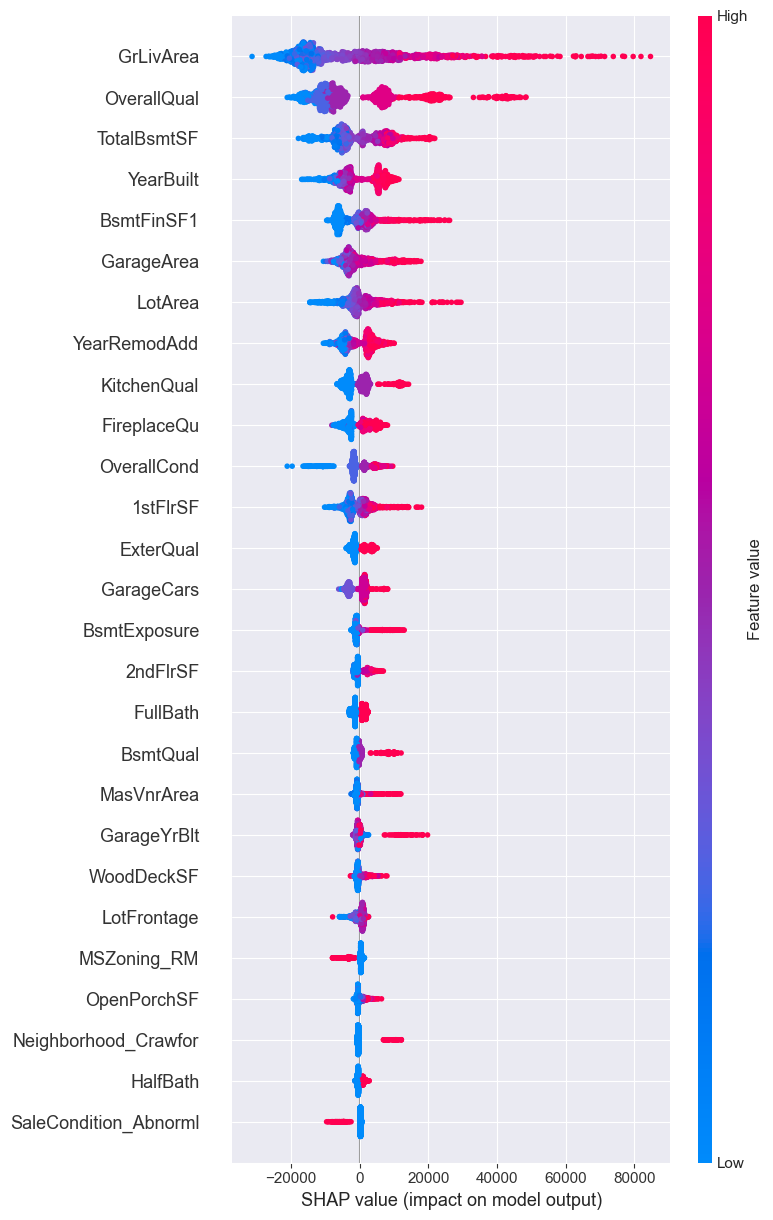

In [360]:
import shap

X_preprocessed = preprocessor.fit_transform(X)
model = XGBRegressor(objective='reg:absoluteerror', learning_rate=0.1, max_depth=3, n_estimators=300, nthread=-1, reg_alpha=1, reg_lambda=1, subsample=0.8)
model.fit(X_preprocessed, y)

explainer = shap.Explainer(model, X_preprocessed)

shap_values = explainer(X_preprocessed)

# Visualize Global Feature Importance
print("Global Feature Importance:")
shap.summary_plot(shap_values, X_preprocessed, max_display=int(X_preprocessed.shape[1] * 0.1))

In [370]:
mi_scores_dict = {}

for k in [3, 5, 10, 20]:
    mi_scores = mutual_info_regression(X_preprocessed, y, n_neighbors=k)
    mi_scores_dict[k] = pd.Series(mi_scores, index=[X_preprocessed.columns]).sort_values(ascending=False)

mi_scores_df = pd.DataFrame(mi_scores_dict)

In [371]:
mi_scores_df[5].sort_values(ascending=False)

OverallQual             0.571626
GrLivArea               0.470503
TotalBsmtSF             0.374880
GarageCars              0.365204
GarageArea              0.354935
                          ...   
Neighborhood_Blueste    0.000000
Functional_Sev          0.000000
MoSold                  0.000000
MiscFeature_TenC        0.000000
Functional_Typ          0.000000
Name: 5, Length: 228, dtype: float64

In [372]:
mi_scores_df[5].sort_values(ascending=False) / mi_scores_df[5].sort_values(ascending=False).sum()

OverallQual             0.055144
GrLivArea               0.045389
TotalBsmtSF             0.036164
GarageCars              0.035231
GarageArea              0.034240
                          ...   
Neighborhood_Blueste    0.000000
Functional_Sev          0.000000
MoSold                  0.000000
MiscFeature_TenC        0.000000
Functional_Typ          0.000000
Name: 5, Length: 228, dtype: float64

In [373]:
(mi_scores_df[5].sort_values(ascending=False) == 0).sum()

np.int64(60)

## Results

Each method showcased unique strengths and limitations, especially in how they handled interactions, non-linearity, and collinearity.

Mutual Information was effective at capturing non-linear dependencies between features and the target variable, providing insights that extended beyond simple correlations. However, it struggled with handling feature interactions and collinearity, often missing redundant or complementary relationships. Despite its simplicity, MI is limited when applied to datasets with complex dependencies.

SHAP proved to be a powerful tool for feature importance analysis, especially for interpreting complex models like Gradient Boosting on trees, as it effectively combines their strengths. Beyond its technical capabilities, SHAP’s interpretability was a significant advantage, providing clear insights into how each feature contributed to the model’s predictions.

Lasso excelled in enforcing sparsity, making it particularly effective for datasets with many irrelevant features. However, its reliance on linearity limited its ability to capture more complex relationships. ElasticNet, which aims to balance sparsity and feature grouping, did not perform well in this case, reducing to Lasso on this dataset.

Gradient Boosting Regression emerged as the best-performing method in terms of predictive accuracy. Its ability to handle complex interactions and non-linear relationships demonstrated its superiority as a modeling approach for both feature selection and regression tasks. As expected, its performance showed the effectiveness of tree-based methods for datasets with diverse feature types.

It is important to recognize the feature importance scores. While it might be tempting to assume that these methods can identify which features decision-makers should manipulate to influence future outcomes, this approach can be misleading in causal inference tasks. Predictive models are not always suitable for guiding policy choices, as they often fail to establish causal relationships.